# 1. Brief description of the problem and data
In this project, I will be creating an algorithm to identify metastatic cancer in small image patches extracted from larger digital pathology scans. To accomplish this, I will be working with a modified version of the PatchCamelyon (PCam) benchmark dataset. This dataset contains a large number of small pathology images that I will use to train and test my algorithm. The goal of the project is to accurately classify the images as either containing or not containing metastatic cancer, based on the presence of tumor tissue in the center 32x32px region of the image patch.

The dataset provided for classification comprises numerous small pathology images, each labeled with an image ID. The ground truth for the images in the train folder is provided in the train_labels.csv file. The objective is to predict the labels for the images in the test folder. A positive label indicates that the central 32x32px area of a patch contains at least one pixel of tumor tissue. It is noteworthy that the tumor tissue present in the outer region of the patch does not affect the label, and is provided for enabling fully-convolutional models that don't use zero-padding, ensuring consistent behavior when applied to a whole-slide image.
Data source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

# 2.Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Loading necessary packages

In [84]:
# Importing  Libraries
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

### I will use 50000 images of each class during training.

In [85]:
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=50000  
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [87]:
##show number of training and testing data 
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [89]:
# Creating a dataframe of training labels
df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(df_data.shape)

(220025, 2)


In [91]:
##count the number of training images in each class
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [96]:
def plot(col_name,figure_cols, df, IMAGE_PATH):
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) 
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) 
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

### Visual inspect of some positive and negative training images

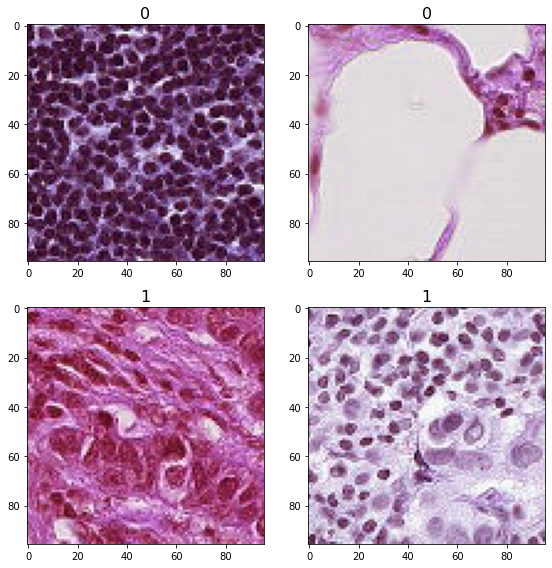

In [99]:
plot('label',2, df_data, '../input/histopathologic-cancer-detection/train/' )

### Create balanced images split during training. 

In [100]:
# Create the Train and Validation Sets using sample_size=50000
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=0)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=0)
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)
df_data['label'].value_counts()

1    50000
0    50000
Name: label, dtype: int64

In [101]:
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)
print(df_train.shape)
print(df_val.shape)

(90000, 2)
(10000, 2)


In [105]:
#create directory for each label
base_dir='base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
negative = os.path.join(train_dir, 'negative')
os.mkdir(negative)
positive = os.path.join(train_dir, 'positive')
os.mkdir(positive)
negative = os.path.join(val_dir, 'negative')
os.mkdir(negative)
positive = os.path.join(val_dir, 'positive')
os.mkdir(positive)

In [106]:
os.listdir('base_dir/train_dir')

['negative', 'positive']

### Make new directory for each label

In [107]:
df_data.set_index('id', inplace=True)

for subset, subset_dir in [(df_train, train_dir), (df_val, val_dir)]:
    for image in tqdm(subset['id']):
        fname = f"{image}.tif"
        target = df_data.loc[image, 'label']
        label = "positive" if target == 1 else "negative"
        src = os.path.join("../input/histopathologic-cancer-detection/train", fname)
        dst = os.path.join(subset_dir, label, fname)
        shutil.copyfile(src, dst)


100%|██████████| 10000/10000 [01:05<00:00, 152.93it/s]


In [109]:
# check number of training images

print("Negative training: ", len(os.listdir('base_dir/train_dir/negative')))
print("Positive training: ", len(os.listdir('base_dir/train_dir/positive')))
print("Negative validation: ", len(os.listdir('base_dir/val_dir/negative')))
print("Positive validation: ", len(os.listdir('base_dir/val_dir/positive')))

45000
45000


# 3.Model Architecture 

### Setting up ImageDataGenerator of training, validation, and testing images

In [113]:
# Set up the generators
train_dir = "base_dir/train_dir"
val_dir = "base_dir/val_dir"
test_dir = "../input/histopathologic-cancer-detection/test"
train_batch_size = 10
val_batch_size = 10
train_steps = -(-len(df_train) // train_batch_size)
val_steps = -(-len(df_val) // val_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')
val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 90000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


### Setting up model architecture using `tensorflow.keras.models.Sequential`. 
#### The deep network has 3 blocks of convolutions, with each of block containing 3 layers. Each block is connected by `Maxpooling` and `Dropout`. Below are a summary of the architecture.

In [114]:
kernel_size = (3, 3)
pool_size = (2, 2)
num_filters = [32, 64, 128]
dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()

# Add convolutional layers with max pooling and dropout
for i, filters in enumerate(num_filters):
    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(96, 96, 3)))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(dropout_conv))

# Flatten and add fully connected layers with dropout
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 41, 64)       

### Modeling compilation and training.

In [115]:
model.compile(Adam(lr=1e-4), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [117]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=1e-5)
callbacks_list = [checkpoint, reduce_lr]
history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
9000/9000 [==============================] - 107s 12ms/step - loss: 0.4611 - accuracy: 0.7865 - val_loss: 0.4285 - val_accuracy: 0.8050
Epoch 2/20
9000/9000 [==============================] - 105s 12ms/step - loss: 0.3726 - accuracy: 0.8369 - val_loss: 0.3825 - val_accuracy: 0.8250
Epoch 3/20
9000/9000 [==============================] - 105s 12ms/step - loss: 0.3313 - accuracy: 0.8561 - val_loss: 0.3401 - val_accuracy: 0.8556
Epoch 4/20
9000/9000 [==============================] - 105s 12ms/step - loss: 0.3085 - accuracy: 0.8682 - val_loss: 0.2772 - val_accuracy: 0.8853
Epoch 5/20
9000/9000 [==============================] - 104s 12ms/step - loss: 0.2900 - accuracy: 0.8777 - val_loss: 0.2689 - val_accuracy: 0.8900
Epoch 6/20
9000/9000 [==============================] - 104s 12ms/step - loss: 0.2758 - accuracy: 0.8858 - val_loss: 0.2864 - val_accuracy: 0.8802
Epoch 7/20
9000/9000 [==============================] - 105s 12ms/step - loss: 0.2633 - accuracy: 0.8912 - val_loss: 0

# 4. Results and Analysis

### Plot the training history

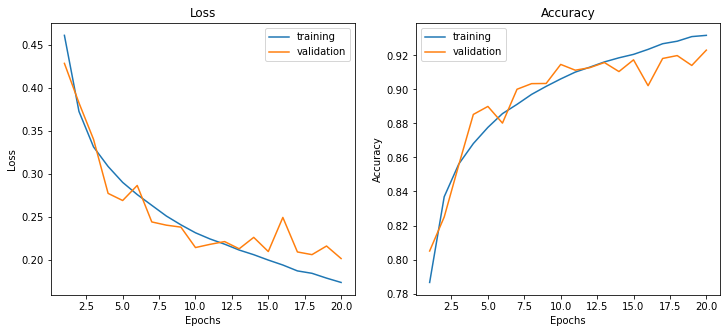

In [120]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, loss, label='training')
ax1.plot(epochs, val_loss, label='validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, label='training')
ax2.plot(epochs, val_acc, label='validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


### Make predictions

In [122]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
df_preds = pd.DataFrame(predictions, columns=['negative', 'positive'])

10000/10000 [==============================] - 20s 2ms/step


In [123]:
y_true = test_gen.classes
y_pred = df_preds['positive']

### ROC
`roc_auc_score` is a metric used to evaluate the performance of binary classification models. It measures the area under the Receiver Operating Characteristic (ROC) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different classification thresholds. The ROC AUC score ranges from 0 to 1, where a score of 0.5 represents a random classifier and a score of 1 represents a perfect classifier. A higher ROC AUC score indicates better model performance in distinguishing between the positive and negative classes.

In [124]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)

0.9752690999999999

### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model. It compares the actual values of a dataset with the predicted values of the model. The positive accuracy and negative accuracy are both high, 0.92 and 0.93 respectively, it means that the model has performed well in both predicting the positive and negative classes.

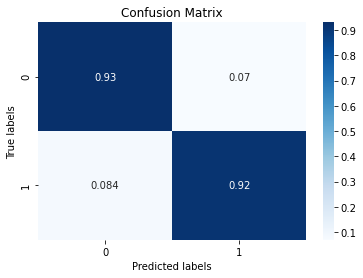

In [137]:
test_labels = test_gen.classes
cm = confusion_matrix(test_labels, predictions.argmax(axis=1),normalize='true')
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

### Precision, Recall, F1

In [132]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5000
           1       0.93      0.92      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# 5.Conclusion
Based on the evaluation metrics, the model has performed well in predicting the classes with an overall accuracy of 92%. The precision, recall, and F1-score for both classes are also high, indicating a good balance between false positives and false negatives. The macro average and weighted average of these metrics are also high and equal, indicating a good balance of the class distribution. Therefore, we can conclude that the model is performing well in predicting the classes and has a good balance between precision and recall.